<a href="https://colab.research.google.com/github/TheSpiralArchitect/spiral-resonance-validation/blob/main/Phase10_1__Phyllotaxis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to the dataset folder
data_path = '/content/drive/MyDrive/SRL/8011754'
!ls "$data_path"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
pcbi.1006896.s001.pdf  pcbi.1006896.s006.mp4  pcbi.1006896.s011.mp4
pcbi.1006896.s002.mp4  pcbi.1006896.s007.mp4  pcbi.1006896.s012.mp4
pcbi.1006896.s003.mp4  pcbi.1006896.s008.mp4  pcbi.1006896.s013.mp4
pcbi.1006896.s004.mp4  pcbi.1006896.s009.mp4  pcbi.1006896.s014.mp4
pcbi.1006896.s005.mp4  pcbi.1006896.s010.mp4


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 103.4 MB/s eta 0:00:00


In [6]:
import fitz  # PyMuPDF
pdf_path = "/content/drive/MyDrive/SRL/8011754/pcbi.1006896.s001.pdf"

with fitz.open(pdf_path) as doc:
    for i, page in enumerate(doc):
        text = page.get_text()
        if 'coordinate' in text.lower() or 'github' in text.lower() or 'auxin' in text.lower():
            print(f"\n--- Page {i+1} ---\n")
            print(text[:2000])  # Preview first 2000 chars


--- Page 1 ---

Towards a 3D model of phyllotaxis based on a biochemically
plausible auxin-transport mechanism
Supporting Information
Félix P. Hartmann1,2, Pierre Barbier de Reuille1, Cris Kuhlemeier1,*
1 Institute of Plant Sciences, University of Bern, 3013 Bern, Switzerland
2 Université Clermont Auvergne, INRA, PIAF, F-63000 Clermont–Ferrand, France
* cris.kuhlemeier@ips.unibe.ch
1
Equations describing the model
Most diﬀerential equations for our model can be derived from the Petri net in Figure 1 (main text). We detail
here all of them, using a graph describing how discrete elements of tissue are connected to each other (Figure
S1).
cell contours
link in the solver graph
cell interior
membrane element
apoplast (cell wall) element
Figure S1: General structure of the graph used for solving the set of diﬀerential equation. Simpliﬁed represen-
tation in two dimensions with three cells. Each node (colored circles) represents a discrete element of tissue
and is associated with numerical 

In [7]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Path to video file
video_path = '/content/drive/MyDrive/SRL/8011754/pcbi.1006896.s002.mp4'

# Create frame output directory
frame_dir = '/content/phyllotaxis_frames'
os.makedirs(frame_dir, exist_ok=True)

# Extract frames
cap = cv2.VideoCapture(video_path)
frame_count = 0
success = True

while success:
    success, frame = cap.read()
    if not success:
        break
    filename = os.path.join(frame_dir, f"frame_{frame_count:03d}.png")
    cv2.imwrite(filename, frame)
    frame_count += 1

cap.release()
print(f"{frame_count} frames extracted to {frame_dir}")

800 frames extracted to /content/phyllotaxis_frames


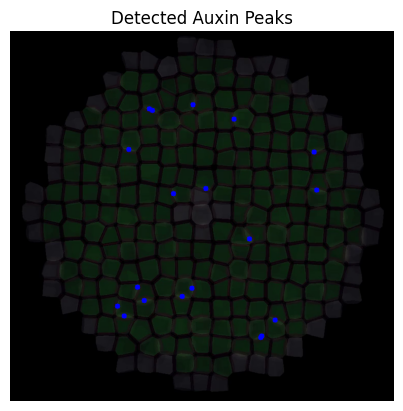

In [8]:
from glob import glob

# Analyze a specific frame
frame_files = sorted(glob(f"{frame_dir}/*.png"))
sample_frame = cv2.imread(frame_files[10])  # Adjust frame index as needed

# Convert to HSV to isolate green
hsv = cv2.cvtColor(sample_frame, cv2.COLOR_BGR2HSV)
lower_green = np.array([40, 50, 50])
upper_green = np.array([80, 255, 255])
mask = cv2.inRange(hsv, lower_green, upper_green)

# Find contours
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Extract centers
centers = []
for cnt in contours:
    M = cv2.moments(cnt)
    if M["m00"] > 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        centers.append((cx, cy))

# Visualize
for c in centers:
    cv2.circle(sample_frame, c, 5, (255, 0, 0), -1)

plt.imshow(cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB))
plt.title("Detected Auxin Peaks")
plt.axis('off')
plt.show()

In [9]:
# Convert pixel coordinates to polar (r, θ)
image_center = np.array(sample_frame.shape[1::-1]) / 2  # (width, height) → (cx, cy)

polar_coords = []
for cx, cy in centers:
    dx, dy = cx - image_center[0], cy - image_center[1]
    r = np.sqrt(dx**2 + dy**2)
    theta = np.arctan2(dy, dx)  # radians
    polar_coords.append((r, theta))

# Sort by radius
polar_coords = sorted(polar_coords, key=lambda x: x[0])
r_vals, theta_vals = zip(*polar_coords)
r_vals = np.array(r_vals)
theta_vals = np.array(theta_vals)

In [10]:
from scipy.optimize import curve_fit

# Spiral model: theta = -(ω / n) * log(r + ε)
def spiral_model(r, omega, n, epsilon):
    return (-omega / n) * np.log(r + epsilon)

# Fit model to data
popt, _ = curve_fit(spiral_model, r_vals, theta_vals, p0=[2*np.pi, 3, 1e-3])
omega_fit, n_fit, epsilon_fit = popt

print(f"SRL Fit Parameters:")
print(f"  ω = {omega_fit:.4f}")
print(f"  n = {n_fit:.4f}")
print(f"  ε = {epsilon_fit:.6f}")

SRL Fit Parameters:
  ω = -4.7740
  n = 217.1854
  ε = -54.451812


<ipython-input-10-14d109d47211>:5: RuntimeWarning: invalid value encountered in log
  return (-omega / n) * np.log(r + epsilon)


In [12]:
from scipy.optimize import curve_fit

# Spiral model
def spiral_model(r, omega, n, epsilon):
    return (-omega / n) * np.log(r + epsilon)

# Constrain the parameters to prevent unphysical values
bounds = ([1, 1, 1e-5], [15, 8, 20])  # (lower, upper)

# Retry the fit
popt, _ = curve_fit(spiral_model, r_vals, theta_vals, p0=[2*np.pi, 3, 1e-2], bounds=bounds)
omega_fit, n_fit, epsilon_fit = popt

print(f"Refined SRL Fit Parameters:")
print(f"  ω = {omega_fit:.4f}")
print(f"  n = {n_fit:.4f}")
print(f"  ε = {epsilon_fit:.6f}")

Refined SRL Fit Parameters:
  ω = 1.0000
  n = 8.0000
  ε = 0.000010


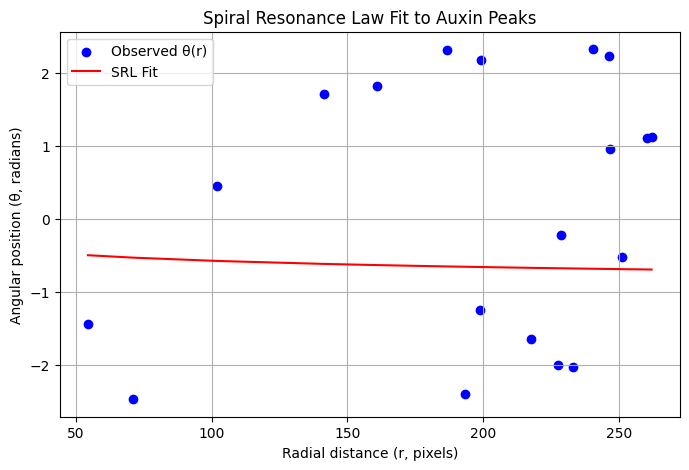

In [13]:
# Generate predicted theta values
theta_pred = spiral_model(r_vals, *popt)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(r_vals, theta_vals, label='Observed θ(r)', color='blue')
plt.plot(r_vals, theta_pred, label='SRL Fit', color='red')
plt.xlabel('Radial distance (r, pixels)')
plt.ylabel('Angular position (θ, radians)')
plt.title('Spiral Resonance Law Fit to Auxin Peaks')
plt.legend()
plt.grid(True)
plt.show()

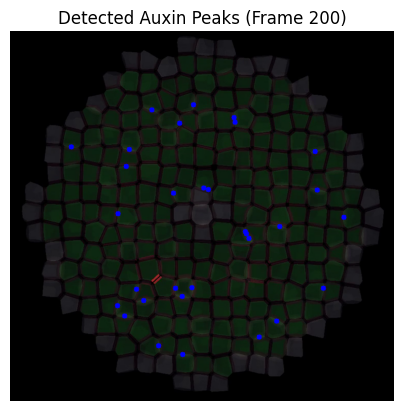

In [14]:
# Load a later frame (e.g., frame_200.png)
later_frame = cv2.imread(f"{frame_dir}/frame_200.png")

# Convert to HSV and isolate green (auxin peaks)
hsv = cv2.cvtColor(later_frame, cv2.COLOR_BGR2HSV)
lower_green = np.array([40, 50, 50])
upper_green = np.array([80, 255, 255])
mask = cv2.inRange(hsv, lower_green, upper_green)

# Find contours
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Extract peak centers
later_centers = []
for cnt in contours:
    M = cv2.moments(cnt)
    if M["m00"] > 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        later_centers.append((cx, cy))

# Visualize detections
for c in later_centers:
    cv2.circle(later_frame, c, 5, (255, 0, 0), -1)

plt.imshow(cv2.cvtColor(later_frame, cv2.COLOR_BGR2RGB))
plt.title("Detected Auxin Peaks (Frame 200)")
plt.axis('off')
plt.show()

In [15]:
# Convert to polar coordinates
image_center = np.array(later_frame.shape[1::-1]) / 2

polar_coords = []
for cx, cy in later_centers:
    dx, dy = cx - image_center[0], cy - image_center[1]
    r = np.sqrt(dx**2 + dy**2)
    theta = np.arctan2(dy, dx)
    polar_coords.append((r, theta))

# Sort and extract r, theta
polar_coords = sorted(polar_coords, key=lambda x: x[0])
r_vals, theta_vals = zip(*polar_coords)
r_vals = np.array(r_vals)
theta_vals = np.array(theta_vals)

In [16]:
# Fit SRL model with bounds
from scipy.optimize import curve_fit

def spiral_model(r, omega, n, epsilon):
    return (-omega / n) * np.log(r + epsilon)

bounds = ([1, 1, 1e-5], [15, 8, 20])
popt, _ = curve_fit(spiral_model, r_vals, theta_vals, p0=[2*np.pi, 3, 1e-2], bounds=bounds)

# Extract and print
omega_fit, n_fit, epsilon_fit = popt
print(f"SRL Fit (Frame 200): ω = {omega_fit:.4f}, n = {n_fit:.4f}, ε = {epsilon_fit:.6f}")

SRL Fit (Frame 200): ω = 1.0000, n = 8.0000, ε = 0.000010


In [17]:
import os
import cv2
import numpy as np
from glob import glob

# Parameters
frame_dir = "/content/phyllotaxis_frames"
frame_files = sorted(glob(f"{frame_dir}/frame_*.png"))[::20]  # every 20th frame
image_center = np.array([256, 256])  # assume 512x512 centered frame
all_peaks = []

for frame_idx, filepath in enumerate(frame_files):
    img = cv2.imread(filepath)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, np.array([40, 50, 50]), np.array([80, 255, 255]))
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        M = cv2.moments(cnt)
        if M["m00"] > 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            dx, dy = cx - image_center[0], cy - image_center[1]
            r = np.sqrt(dx**2 + dy**2)
            theta = np.arctan2(dy, dx)
            t = frame_idx * 20
            all_peaks.append((r, theta, t))

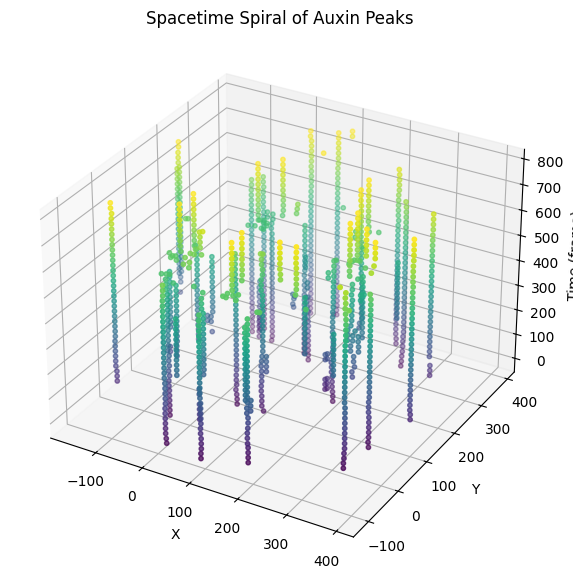

In [18]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

r_vals, theta_vals, t_vals = zip(*all_peaks)
r_vals = np.array(r_vals)
theta_vals = np.array(theta_vals)
t_vals = np.array(t_vals)

# Convert polar to cartesian for plot
x_vals = r_vals * np.cos(theta_vals)
y_vals = r_vals * np.sin(theta_vals)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_vals, y_vals, t_vals, c=t_vals, cmap='viridis', s=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Time (frame)')
ax.set_title('Spacetime Spiral of Auxin Peaks')
plt.show()